# Pneumonia_Training

Versions

* v001_Initial commit

Imports

In [1]:
# general
import numpy as np
import pandas as pd
import os
import pydicom
import matplotlib.pyplot as plt
import datetime

# keras
# from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

C:\Users\Lorenzo\Anaconda3\envs\rsna\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Constants

In [3]:
DATA_DIR = os.path.join(os.path.expandvars('%HOMEPATH%'), 'Downloads/Data')

TRAIN_DCM = os.path.join(DATA_DIR, "stage_1_train_images")
TEST_DCM = os.path.join(DATA_DIR, "stage_1_test_images")
TRAIN_IMAGES = os.path.join(DATA_DIR, "train_images")
TEST_IMAGES = os.path.join(DATA_DIR, "test_images")

TRAIN_FEATURES_DIR = os.path.join(TRAIN_IMAGES, 'features')

os.listdir(TRAIN_FEATURES_DIR)[:10]

FileNotFoundError: [WinError 3] The system cannot find the path specified: '\\Users\\Lorenzo\\Downloads/Data\\train_images\\features'

## Extract features using NN

In [14]:
# general
import numpy as np
import pandas as pd
import os
import pydicom
from scipy import misc

In [17]:
def dcm2np(dcm_path, target_size=(224, 224)):
    """ Transforms a dcm into a np.array
    """
    # --- Open DICOM file
    d = pydicom.read_file(dcm_path)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)
    
    im = scipy.misc.imresize(im, target_size, interp='bilinear', mode=None)
    
    return im

In [18]:
gna = dcm2np(r'C:\Users\loren\Downloads\stage_1_train_images\00aecb01-a116-45a2-956c-08d2fa55433f.dcm')

gna.shape

C:\Users\loren\Anaconda3\envs\rsna\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(224, 224, 3)

In [5]:
def _get_feature_values(img_path, model):
    """ Get the feature values for a specific image out of pre-trained model 
    """
    im = dcm2np(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x)[0].reshape(-1)

def _create_pretrained_feature_df(class_directory):
    """ Create features dataframe based on pretrained model 
    """
    features = []
    n_max = len(os.listdir(class_directory))
    divisor = 100
    for n, file in enumerate(os.listdir(class_directory)):
        if( n % (n_max/divisor) ==0 ):
            print('Scoring image {0}'.format(n/n_max))
        full_path = os.path.join(class_directory, file)
        features.append(_get_feature_values(full_path, model))
    return pd.DataFrame(np.stack(features))

def _build_basic_rf(df):
    """ Build basic random forest based on extracted pre-trained model 
    """
    x_train, x_test, y_train, y_test = train_test_split(df[df.columns.difference(["Target"])], df["Target"])
    rf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=15, n_jobs=-1, class_weight="balanced")
    rf.fit(x_train, y_train)
    train_preds = rf.predict_proba(x_train)
    test_preds = rf.predict_proba(x_test)
    print(f"AUC for train set is {roc_auc_score(y_train, train_preds[:,1])}")
    print(f"AUC for test set is {roc_auc_score(y_test, test_preds[:,1])}")
    return rf

In [ ]:
model = InceptionV3(weights='imagenet', include_top=False)

pos_df = _create_pretrained_feature_df(os.path.join(TRAIN_IMAGES, "positive"))
pos_df["Target"] = 1

neg_df = _create_pretrained_feature_df(os.path.join(TRAIN_IMAGES, "negative"))
neg_df["Target"] = 0

full_df = pd.concat([pos_df, neg_df])

In [10]:
pos_df.to_csv(os.path.join(DATA_DIR, 'Inception_v3_positive.csv'))

In [6]:
rf_trained = _build_basic_rf(full_df)

Scoring image 0.0
Scoring image 0.0
Scoring image 4.0
Scoring image 8.0


OSError: image file is truncated

## Classifiers

In [2]:
classifiers = {
    "Nearest Neighbors":KNeighborsClassifier(3),
    "Linear SVM":SVC(kernel="linear", C=0.025),
    "RBF SVM":SVC(gamma=2, C=1),
    "Gaussian Process":GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    "Decision Tree":DecisionTreeClassifier(max_depth=5),
    "Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Net":MLPClassifier(alpha=1),
    "AdaBoost":AdaBoostClassifier(),
    "Naive Bayes":GaussianNB(),
    "QDA":QuadraticDiscriminantAnalysis()
}

In [3]:
os.listdir('C:/Users/Lorenzo/Downloads')[:10]

['001_2349-202 - Courtyard - CON04 - B19 to C6 (HOLLO-BOLTED CONNECTION).pdf',
 '001_WC1-2940-LML-DOC-00-0078_iss1_rev00.docx',
 '001_WC1-2940-LML-DOC-00-0078_iss1_rev00.rtf',
 '001_WC1-2940-LML-DOC-00-0078_iss1_rev00.txt',
 '001_WC1-2940-LML-DOC-00-0078_iss1_rev00_from docx.txt',
 '003_overview.pdf',
 '00A45_72f41924012c4e95b0d52f50b2a9b94d_a8f1c3e0d61448ffa436dac6ca1c36b2.dataset',
 '02-02-2016-2.pdf',
 '03012015_caigui_The ground structure method.pptx',
 '04.06-selected (1).zip']

In [51]:
subset = 400

df_positive = pd.read_csv('C:/Users/Lorenzo/Downloads/VGG16_05006.csv', index_col=0)
df_negative = pd.read_csv('C:/Users/Lorenzo/Downloads/VGG16_05658.csv', index_col=0)
df_negative = df_negative.iloc[:len(df_positive)]

df_positive = df_positive.iloc[:subset]
df_negative = df_negative.iloc[:subset]

df_positive['Target'] = 1
df_negative['Target'] = 0

if(len(df_positive) != len(df_negative)):
    raise Exception()
    
df = pd.concat([df_positive, df_negative])
len(df)

800

In [52]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,Target
0,26.100794,20.245167,19.934593,8.966306,0.520192,0.000000,18.298653,31.527435,53.699146,13.956929,...,20.877249,16.742640,19.429853,0.000000,19.590073,3.595904,7.531466,28.923544,11.218239,1
1,16.955046,0.000000,8.695172,15.246630,0.946223,0.000000,5.583616,26.391163,32.693290,18.645735,...,10.337791,28.005089,13.988813,0.000000,13.814245,2.007999,0.000000,14.498714,0.000000,1
2,15.366793,15.375629,22.566637,9.086631,8.967999,0.929143,8.994421,10.629556,14.519496,20.628174,...,3.891536,36.116947,30.983765,0.000000,31.688375,0.000000,8.614918,40.333740,0.687932,1
3,32.840855,23.118294,5.727360,10.679402,9.392455,0.000000,0.245977,27.909891,48.765907,22.981410,...,24.171293,36.237583,42.976910,0.278415,41.208240,0.000000,13.466224,28.233995,8.741349,1
4,6.526724,0.000000,9.810153,0.000000,0.000000,54.345028,4.497581,20.263136,27.236887,5.799153,...,3.012163,35.822132,25.237528,1.393787,19.999416,15.951019,2.914543,31.903246,0.000000,1


## Prepare feature dataset 

In [53]:
X = df.drop('Target', axis=1)
Y = df['Target']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=42)

h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

## Classification

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          index=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    rows=3
    ax = plt.subplot((len(classifiers) // rows) +1, rows, index+1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

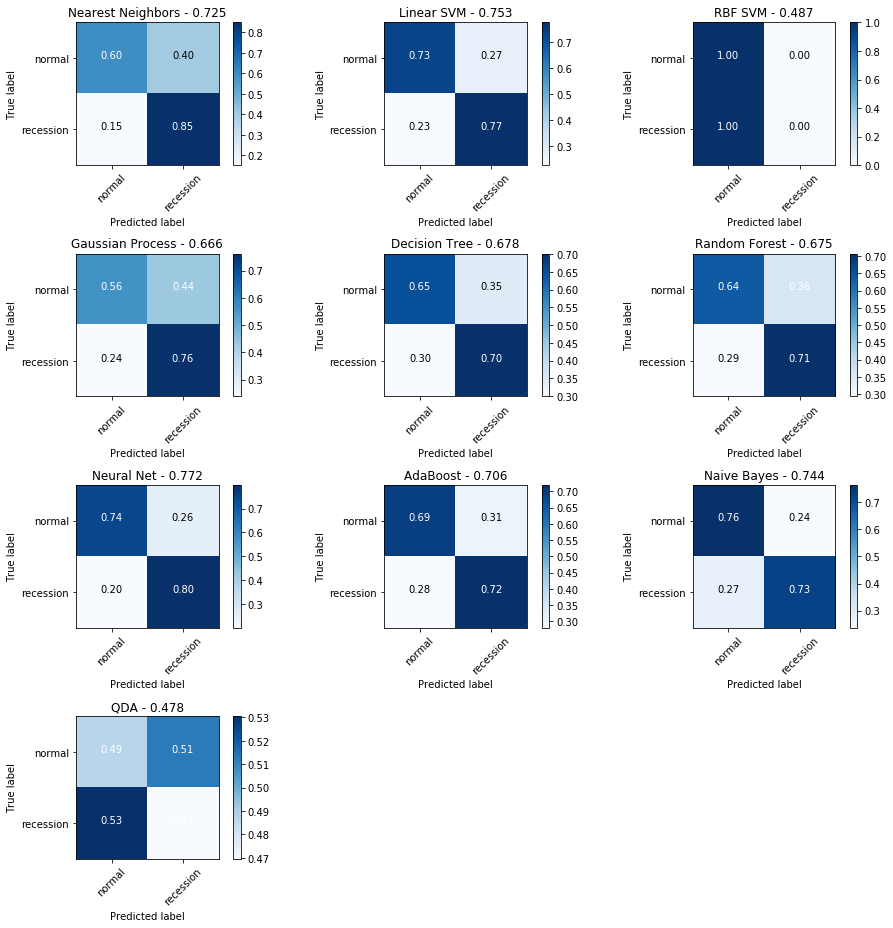

In [79]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(13, 13))

#X_train, X_test, y_train, y_test
for i, (name, clf) in enumerate(classifiers.items()):
    Y2_test = y_test
    Y2_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
             
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y2_test, Y2_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    
    plot_confusion_matrix(cnf_matrix, 
                          classes=['normal', 'recession'], 
                          normalize=True,
                          title='{0} - {1:.3f}'.format(name, score),
                          index=i)

plt.tight_layout()
plt.show()

## Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron, PassiveAggressiveRegressor, LogisticRegression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20


    
class XgbWrapper(object):
    def __init__(self, seed=0):
        self.params = {"objective": "reg:linear", "booster":"gblinear"}
        self.nrounds = 250

    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.params, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

classifiers = {
    "PLSRegression": PLSRegression(n_components=2),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "MLPRegressor": MLPRegressor(max_iter=200,hidden_layer_sizes=(50)),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5 ),
    "LinearRegression": LinearRegression(),
    "ElasticNet": ElasticNet(),
}